In [36]:
import pickle
import time
import datetime
import os.path
import matplotlib.pyplot as plt
import numpy as np
import random

f = open('history.dat', 'rb')
history_arr = pickle.load(f)


In [37]:
def make_chart_arr(arr):
    
    tm = []
    val = []
    
    for v in arr:
        open =  float(v[1])
        high =  float(v[2])
        low =   float(v[3])
        close = float(v[4])
        
        start_time = v[0]
        end_time = v[6]
        
        up_rotated = True
        if(len(val)>=4):
            up_rotated = open <= val[-4]
        
        tm.append(start_time)
        val.append(open)

        line_points = 5
        
        if up_rotated:
            for j in range(1,line_points):
                val.append(open+(high-open)*j/line_points)
                
            val.append(high)
            
            for j in range(1,line_points):
                val.append(high+(low-high)*j/line_points)
                
            val.append(low)
        
            for j in range(1,line_points):
                val.append(low+(close-low)*j/line_points)
        else:
            for j in range(1,line_points):
                val.append(open+(low-open)*j/line_points)
                
            val.append(low)
            
            for j in range(1,line_points):
                val.append(low+(high-low)*j/line_points)
                
            val.append(high)
        
            for j in range(1,line_points):
                val.append(high+(close-high)*j/line_points)
        
        for j in range(1,line_points*3):
            tm.append(int(start_time+(end_time-start_time)*j/(line_points*3)) )

        tm.append(end_time)
        val.append(close)
    
    return [tm,val]






In [45]:
def findDateIndex(date):
    unix_time = int(datetime.datetime.timestamp(date)*1000)
    index = 0
    for v in history_arr:
        if v[0]>=unix_time:
            break
        index += 1;
    return index
    
from_index = findDateIndex(datetime.datetime(2022, 6, 14, 0, 0,0))
#from_index = findDateIndex(datetime.datetime(2022, 7, 1, 0, 0,0))
#to_index = findDateIndex(datetime.datetime(2022, 6, 14, 0, 0,0))

#x,y = make_chart_arr(history_arr)
#x,y = make_chart_arr(history_arr[from_index:to_index])
x,y = make_chart_arr(history_arr[from_index:])

min_price = min(y)
max_price = max(y)

date_time = datetime.datetime.fromtimestamp(x[0]/1000)
print("from=", date_time.strftime('%Y-%m-%d %H:%M:%S'))

date_time = datetime.datetime.fromtimestamp(x[-1]/1000)
print("to=", date_time.strftime('%Y-%m-%d %H:%M:%S'))

print("min_price=", min_price)
print("max_price=", max_price)


from= 2022-06-14 00:00:00
to= 2022-08-11 22:58:59
min_price= 17622.0
max_price= 24918.54


In [46]:
day_x=np.arange(0,len(x),dtype=float)
IDX_IN_DAY = 24*60*16
day_x /= IDX_IN_DAY


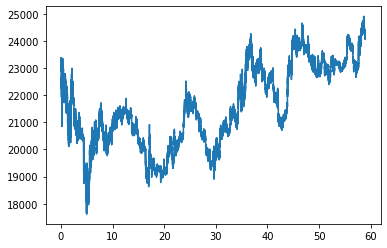

In [47]:

plt.plot(day_x,y)
plt.show()


In [48]:
gr_dist = [15*16,5*16,1*16]
gr_min = [(-450/20000),(350/20000),(-100/20000)]

def isGrowGradient(idx,price):
    gr = [0,0,0]
    global gr_min
    
    for i in range(0,len(gr)):
        if idx>=gr_dist[i]:
            gr_price = y[idx-gr_dist[i]]
            gr[i] = price/gr_price
     
    for i in range(0,len(gr)):
        if gr[i]<gr_min[i]:
            return False
    
    return True

initMoney = 100
money = initMoney

bye_points = []
sell_points = []
loss_points = []

order_points = []
order_money = []

SEARCH_BUY = 1
BUY = 2
SEARCH_SELL = 3
SEARCH_LOSS = 4

def scanRound():
    global money

    global bye_points
    global sell_points
    global loss_points

    global order_points
    global order_money
    
    
    money = initMoney
    btc = 0

    state = SEARCH_BUY
    stopTriggerPrice = 0
    stopPrice = 0
    limitPrice = 0

    bye_points = []
    sell_points = []
    loss_points = []

    order_points = []
    order_money = []

    next_random = int(random.random()*16)

    for i in range(4,len(y)):
        price = y[i]

        if state == SEARCH_BUY:
            if (i%16)==next_random and isGrowGradient(int(i/16)*16,price):
                next_random = int(random.random()*16)
                state = BUY
        elif state == BUY:
            btc = money/price
            money = 0

            order_points.append(day_x[i]);
            order_money.append(money+btc*price);
            bye_points.append(day_x[i])
            #print(i,i/IDX_IN_DAY,"buy: price=",price,"btc=",btc)

            stopTriggerPrice = price*(19600/20000)
            stopPrice = 0
            limitPrice = price*(20060/20000)

            #print("order: limitPrice=",limitPrice,"stopTriggerPrice=",stopTriggerPrice,"stopPrice=",stopPrice)

            state = SEARCH_SELL
        elif state == SEARCH_SELL:
            if price >= limitPrice:
                money = btc * price
                btc = 0

                order_points.append(day_x[i]);
                order_money.append(money+btc*price);
                sell_points.append(day_x[i])
                #print(i,i/IDX_IN_DAY,"sell: price=",price,"money=",money)
                state = SEARCH_BUY
            elif price<=stopTriggerPrice:
                state = SEARCH_LOSS

        elif state == SEARCH_LOSS:
            if price >= stopPrice:
                money = btc * price
                btc = 0

                order_points.append(day_x[i]);
                order_money.append(money+btc*price);
                loss_points.append(day_x[i])
                #print(i,i/IDX_IN_DAY,"loss sell: price=",price,"money=",money)
                state = SEARCH_BUY


    price = y[-1]
    money += btc * price
    btc = 0
    order_points.append(day_x[-1]);
    order_money.append(money+btc*price);
    
    print("money=",money)
    print("state=",state)
    print("bye_points:",len(bye_points),"sell_points:",len(sell_points),"loss_points:",len(loss_points))
            
scanRound()            
                
            
        
            
        




money= 127.67579050713317
state= 3
bye_points: 1619 sell_points: 1404 loss_points: 214


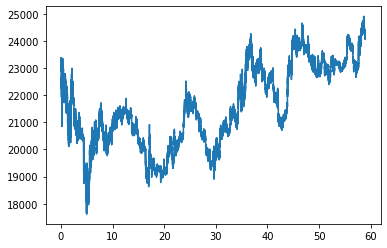

In [49]:
plt.plot(day_x,y)

#for p in bye_points:
#    plt.vlines(p,min_price,max_price,color='green')

#for p in sell_points:
#    plt.vlines(p,min_price,max_price,color='grey')

#for p in loss_points:
#    plt.vlines(p,min_price,max_price,color='red')

plt.show()

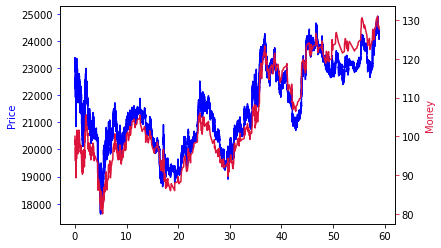

In [50]:
fig, ax1 = plt.subplots()
color1 ='blue'
ax1.plot(day_x,y, color = color1)
ax1.set_ylabel('Price',color = color1);
ax1.tick_params(axis='y',color = color1);

color2 ='crimson'
ax2 = ax1.twinx();
ax2.plot(order_points,order_money, color = color2)
ax2.set_ylabel('Money', color = color2);
ax2.tick_params(axis='y',color = color2);

